In [97]:
import pandas as pd
import numpy as np 
import glob
import os
import json
from PIL import Image 
import tensorflow as tf 
import tensorflow_datasets as tfds 
import pathlib
import os
import requests
import keras
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
import random
from sklearn.metrics import accuracy_score
import time
from scipy.ndimage.filters import gaussian_filter
from skimage import restoration
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Flatten
from tensorflow.keras.optimizers import Adam
from collections import deque
import random
import cv2



<ipython-input-97-0460407628fd>:19: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter


In [98]:
os.chdir("/content/drive/MyDrive/Thesis Folder/Dataset/Subset105/icub_left")

In [ ]:
'''labels=pd.read_csv("/content/drive/MyDrive/Thesis Folder/Dataset/Subset105/labels.txt", sep=' ', names=["Number", "Object"])
labels=labels.iloc[:40,:]
print(labels)'''

'labels=pd.read_csv("/content/drive/MyDrive/Thesis Folder/Dataset/Subset105/labels.txt", sep=\' \', names=["Number", "Object"])\nlabels=labels.iloc[:40,:]\nprint(labels)'

In [ ]:
'''label = labels["Object"].values.tolist()
print(label)'''

'label = labels["Object"].values.tolist()\nprint(label)'

### Load Data
There I am going to try to upload all 105 labels and its respectic images 

In [50]:
'''dataset = []
labels = []
for j in range(len(label)):
  imageNames = glob.glob("{}_{}/*".format(j,label[j]))
  for i, imName in enumerate(imageNames):
    f_img=Image.open(imName)
    img = f_img.resize((64, 64))
    dataset.append(np.array(img))
    labels.append(label[j])
'''


'dataset = []\nlabels = []\nfor j in range(len(label)):\n  imageNames = glob.glob("{}_{}/*".format(j,label[j]))\n  for i, imName in enumerate(imageNames):\n    f_img=Image.open(imName)\n    img = f_img.resize((64, 64))\n    dataset.append(np.array(img))\n    labels.append(label[j])\n'

In [ ]:
'''os.chdir("/content/drive/MyDrive/Thesis Folder/Dataset/Subset105/icub_right")
for j in range(len(label)):
  imageNames = glob.glob("{}_{}/*".format(j,label[j]))
  for i, imName in enumerate(imageNames):
    f_img=Image.open(imName)
    img = f_img.resize((64, 64))
    dataset.append(np.array(img))
    labels.append(label[j])
'''

In [51]:
''' #Convert data shape of (n_of_samples, width, height, 3)

dataset = np.stack(dataset, axis=0)
labels = np.array(labels)
# save data and labels into a folder
np.save("data40t.npy", dataset)
np.save("labels40t.npy", labels)'''

' #Convert data shape of (n_of_samples, width, height, 3)\n\ndataset = np.stack(dataset, axis=0)\nlabels = np.array(labels)\n# save data and labels into a folder\nnp.save("data40.npy", dataset)\nnp.save("labels40.npy", labels)'

In [52]:
'''dataset.shape
labels.shape
dataset= None
labels=None'''

'dataset.shape\nlabels.shape\ndataset= None\nlabels=None'

### Pre process 
here I am actually starting to work 


In [78]:
features = np.load("/content/drive/MyDrive/Thesis Folder/Dataset/Subset105/icub_left/data40.npy")
labels = np.load("/content/drive/MyDrive/Thesis Folder/Dataset/Subset105/icub_left/labels40.npy")

########features = np.load("/home/u784210/Thesis/data40.npy")
########labels = np.load("/home/u784210/Thesis/labels40.npy")

In [79]:

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    features, labels, test_size=0.2, random_state=42, stratify=labels)

# Further split the training set into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.25, random_state=42, stratify=y_train)



In [46]:
print(len(X_train))
print(len(X_val))
print(len(X_test))
X_test.shape
labels.shape

1728
576
576


(2880,)

In [47]:

#making them float 
X_train=X_train.astype('float32')
X_val=X_val.astype('float32')

#Normalizing the data between 0 and 1 
X_train=X_train/255.0
X_val=X_val/255.0



In [48]:
## label names 
####labels=pd.read_csv("/home/u784210/Thesis/labels.txt", sep=' ', names=["Number", "Object"])

labels=pd.read_csv("/content/drive/MyDrive/Thesis Folder/Dataset/Subset105/labels.txt", sep=' ', names=["Number", "Object"])
labels=labels.iloc[:40,:]
label = labels["Object"].values.tolist()

#Categorical encoding 
label_map = {}
for i in range(len(label)):
  label_map[str(label[i])]=i

# Encode the categorical labels as numerical values using the label map
y_train_encoded = np.vectorize(label_map.get)(y_train)
y_val_encoded = np.vectorize(label_map.get)(y_val)

# Convert the numerical labels to one-hot encoded format
num_classes = len(label)
y_train_onehot = keras.utils.to_categorical(y_train_encoded, num_classes=num_classes)
y_val_onehot = keras.utils.to_categorical(y_val_encoded, num_classes=num_classes)



In [49]:

seed = 42
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)

optimizer = keras.optimizers.Adam(learning_rate=0.001)

def build_baseline_model():
    model = keras.Sequential([
        # Convolutional layers
        keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', input_shape=(64, 64, 3)),
        keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
        keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu'),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
        keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu'),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
       
        
        # Dense layers
        keras.layers.Flatten(),
        keras.layers.Dense(32, activation='relu'),
        keras.layers.Dense(32, activation='relu'),
        keras.layers.Dense(40, activation='softmax')
    ])

    # Compile the model with appropriate loss function, optimizer, and metrics
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    return model


baseline_model = build_baseline_model()

# Train the model for 12 epochs with a batch size of 32
history = baseline_model.fit(
    X_train,
    y_train_onehot,
    batch_size=32,
    epochs=12,
    validation_data=(X_val, y_val_onehot)
)

Epoch 1/12
54/54 [==============================] - 62s 1s/step - loss: 3.8710 - accuracy: 0.0231 - val_loss: 3.6990 - val_accuracy: 0.0208
Epoch 2/12
54/54 [==============================] - 79s 1s/step - loss: 3.1089 - accuracy: 0.1493 - val_loss: 2.6001 - val_accuracy: 0.2604
Epoch 3/12
54/54 [==============================] - 62s 1s/step - loss: 2.0283 - accuracy: 0.3796 - val_loss: 1.2968 - val_accuracy: 0.5538
Epoch 4/12
54/54 [==============================] - 70s 1s/step - loss: 1.3494 - accuracy: 0.5584 - val_loss: 1.1737 - val_accuracy: 0.6458
Epoch 5/12
54/54 [==============================] - 64s 1s/step - loss: 0.9476 - accuracy: 0.6626 - val_loss: 0.7469 - val_accuracy: 0.7101
Epoch 6/12
54/54 [==============================] - 64s 1s/step - loss: 0.7279 - accuracy: 0.7604 - val_loss: 0.4996 - val_accuracy: 0.8420
Epoch 7/12
54/54 [==============================] - 66s 1s/step - loss: 0.4984 - accuracy: 0.8258 - val_loss: 0.3930 - val_accuracy: 0.8646
Epoch 8/12
54/54 [==

In [18]:
baseline_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 64)        1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 32)        18464     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 30, 30, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 26, 26, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                    

In [53]:
# Save the model summary to a text file
with open('model_summary.txt', 'w') as f:
    # Redirect the print statement to the file
    print(baseline_model.summary(), file=f)

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 62, 62, 64)        1792      
                                                                 
 conv2d_7 (Conv2D)           (None, 60, 60, 32)        18464     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 30, 30, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 conv2d_9 (Conv2D)           (None, 26, 26, 32)        18464     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                  

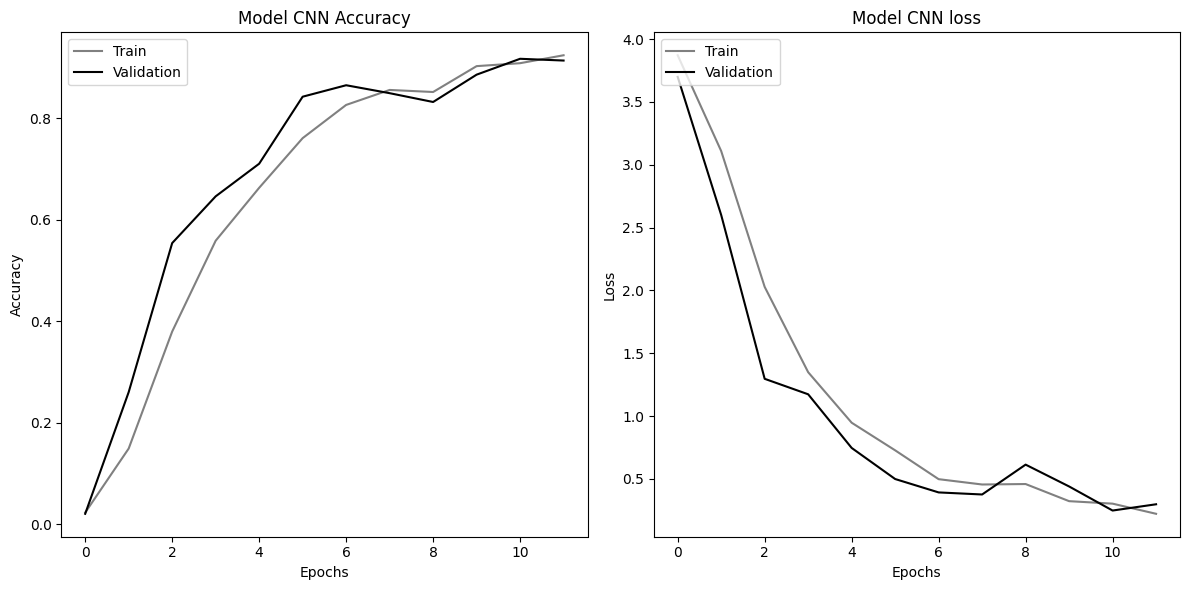

In [54]:


#Plot training ,validation accuracy values
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], color='gray')
plt.plot(history.history['val_accuracy'], color='black')
plt.title('Model CNN Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Validation'], loc='upper left')

#Plot training, validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], color='gray')
plt.plot(history.history['val_loss'], color='black')
plt.title('Model CNN loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()



In [55]:
baseline_all_val_acc = np.mean(history.history["val_accuracy"])
baseline_all_val_loss = np.mean(history.history["val_loss"])
print("BASELINE RESULTS:")
print("-"*len("BASELINE RESULTS:"))
print()
print("The average validation accuracy among all epochs is: {}".format(baseline_all_val_acc))
print("The average validation loss among all epochs is: {}".format(baseline_all_val_loss))

BASELINE RESULTS:
-----------------

The average validation accuracy among all epochs is: 0.6911168885417283
The average validation loss among all epochs is: 1.0323063172399998


### Blur test data 


In [ ]:
'''

images = np.load('../images.npy')
sigma = random.randint(1, 10)

# Loop through each image in the stack and apply the Gaussian blur filter in some of them 
for i in range(int(len(X_test)/2)):
    idx=random.randint(0, int(len(X_test-1)))

    blurred_image = np.empty_like(X_test[idx])
    for j in range(3):
        blurred_image[..., j] = gaussian_filter(X_test[idx][..., j], sigma)
    X_test[idx] = blurred_image

# Save the blurred images to a new file
np.save('../blurredmix_images40.npy', X_test)

len(X_test)'''


"import numpy as np\nfrom scipy.ndimage.filters import gaussian_filter\nimport random\n\n#images = np.load('../images.npy')\nsigma = random.randint(1, 10)\n\n# Loop through each image in the stack and apply the Gaussian blur filter in some of them \nfor i in range(int(len(X_test)/2)):\n    idx=random.randint(0, int(len(X_test-1)))\n\n    blurred_image = np.empty_like(X_test[idx])\n    for j in range(3):\n        blurred_image[..., j] = gaussian_filter(X_test[idx][..., j], sigma)\n    X_test[idx] = blurred_image\n\n# Save the blurred images to a new file\nnp.save('../blurredmix_images40.npy', X_test)\n\nlen(X_test)"

### Data Test Split 

In [80]:
#Split sets 
##########Dataset_DQL_X=np.load("/home/u784210/Thesis/blurredmix_images40.npy")
Dataset_DQL_X=np.load("../blurredmix_images40.npy")
Dataset_DQL_y=y_test



In [81]:
X_test=None
y_test=None

print(Dataset_DQL_X.shape, Dataset_DQL_y.shape)


(576, 64, 64, 3) (576,)


In [82]:
X_train, X_test, y_train, y_test = train_test_split( Dataset_DQL_X, Dataset_DQL_y , test_size=0.2, random_state=42, stratify=Dataset_DQL_y)
# Further split the training set into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.25, random_state=42, stratify=y_train)

In [83]:
print(len(X_train))
print(len(X_val))
print(len(X_test))
print(len(y_test))

345
115
116
116


## Encoding for DQL 


In [84]:
X_train=X_train.astype('float32')
X_val=X_val.astype('float32')

X_test=X_test.astype('float32')

X_train=X_train/255.0
X_val=X_val/255.0

X_test=X_test/255.0

#Categorical encoding 
label_map = {}
for i in range(len(label)):
  label_map[str(label[i])]=i

# Encode the categorical labels as numerical values using the label map
y_train_encoded = np.vectorize(label_map.get)(y_train)
y_val_encoded = np.vectorize(label_map.get)(y_val)

y_test_encoded = np.vectorize(label_map.get)(y_test)

# Convert the numerical labels to one-hot encoded format
num_classes = len(label)
y_train_onehot = keras.utils.to_categorical(y_train_encoded, num_classes=num_classes)
y_val_onehot = keras.utils.to_categorical(y_val_encoded, num_classes=num_classes)

y_test_onehot = keras.utils.to_categorical(y_test_encoded, num_classes=num_classes)


print(y_test_onehot.shape)
print(X_test.shape)

(116, 40)
(116, 64, 64, 3)


### DRL 

In [ ]:
#Structure inspired by
# https://pythonprogramming.net/deep-q-learning-dqn-reinforcement-learning-python-tutorial/
# https://github.com/philtabor/Deep-Q-Learning-Paper-To-Code
# 
pretrained_model = baseline_model 
data_DRL=X_train

#  the environment
class ImageBlurDeblurEnv:
    
    def __init__(self, X=data_DRL, y=y_train_onehot):        
        self.action_space = [0, 1, 2]  
        # 0: blur, 1: deblur, 2: do nothing
        self.data_indices = np.arange(len(X))
        np.random.shuffle(self.data_indices)
        self.reset(0,X,y)

    def reset(self,i,X=data_DRL,y=y_train_onehot):
        if len(self.data_indices)==len(X):
          idx = self.data_indices[i]
        else: 
          idx=i
        self.image = X[idx]
        self.real_y = y[idx] #is the label of the image in hot encoder
        self.true_class=np.argmax(self.real_y)
        return self.image

    def step(self, action):
        if action == 0:
            self.image = cv2.GaussianBlur(self.image, (5, 5), 0)
        elif action == 1:
            self.image = cv2.addWeighted(self.image, 1.5, cv2.GaussianBlur(self.image, (5, 5), 0), -0.5, 0)
        predicted_output = pretrained_model.predict(np.expand_dims(self.image, axis=0))
        self.predicted_class = np.argmax(predicted_output, axis=1)

        reward = 1 if self.true_class == self.predicted_class else -1
        done = True
        #save
        return self.image, reward, done


# the DQN model
def create_q_model(input_shape, num_actions):
    model = Sequential()
    model.add(Input(input_shape))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(num_actions))
    model.compile(optimizer=Adam(learning_rate=0.01), loss='mse')
    return model

# replay buffer
class ReplayBuffer:
    def __init__(self, buffer_size):
        self.buffer = deque(maxlen=buffer_size)

    def add(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)

    def __len__(self):
        return len(self.buffer)

# Training parameters
EPISODES = 40
BATCH_SIZE = 64
GAMMA = 0.99
EPSILON_START = 1.0
EPSILON_MIN = 0.01
EPSILON_DECAY = 0.995
BUFFER_SIZE = 400
TARGET_UPDATE_FREQ = 10

# Create environment, models, and buffer

env = ImageBlurDeblurEnv(data_DRL, y_train_onehot)
input_shape = (64, 64, 3)
num_actions = len(env.action_space)

q_model = create_q_model(input_shape, num_actions)
target_model = create_q_model(input_shape, num_actions)
target_model.set_weights(q_model.get_weights())
buffer = ReplayBuffer(BUFFER_SIZE)


epsilon = EPSILON_START


"\nfor episode in range(EPISODES):\n   # Shuffle data_indices at the beginning of each episode\n  np.random.shuffle(env.data_indices)\n  for image_idx in range(len(data_DRL)):\n    state = env.reset(image_idx, data_DRL, y_train_onehot)\n    done = False\n    while not done:\n        # Choose action\n        if np.random.rand() < epsilon:\n            action = np.random.choice(env.action_space)\n        else:\n            q_values = q_model.predict(np.expand_dims(state, axis=0))\n            action = np.argmax(q_values)\n\n        # Perform action\n        next_state, reward, done = env.step(action)\n\n        # Store experience in buffer\n        buffer.add(state, action, reward, next_state, done)\n\n        state = next_state\n\n    # Train the model if the buffer has enough samples\n    if len(buffer) >= BATCH_SIZE:\n        batch = buffer.sample(BATCH_SIZE)\n        states, actions, rewards, next_states, dones = zip(*batch)\n\n        states = np.array(states)\n        actions = np.

In [ ]:
''' #Potential deblur technique
def deblur_img(img):
  #let's assume a Gaussian blur and create a PSF for that.
  psf = np.ones((5, 5)) / 25
  # Perform deconvolution using the Wiener algorithm for each color channel
  deblurred_image = np.zeros_like(img)
  for i in range(3):
    deblurred_image[:,:,i] = restoration.wiener(img[:,:,i], psf, 1, clip=False)
  return deblurred_image
'''


#### Validation set DQL

In [89]:

learning_rates = [0.001, 0.01, 0.1]
discount_factors = [0.9, 0.95, 0.99]

validation_data = X_val  

best_performance = -float('inf')
best_hyperparameters = {}

for lr in learning_rates:
    for gamma in discount_factors:
        # Create environment, models, and buffer
        env = ImageBlurDeblurEnv(data_DRL, y_train_onehot)
        input_shape = (64, 64, 3)
        num_actions = len(env.action_space)

        q_model = create_q_model(input_shape, num_actions)
        target_model = create_q_model(input_shape, num_actions)
        target_model.set_weights(q_model.get_weights())
        buffer = ReplayBuffer(BUFFER_SIZE)

        # Set hyperparameters
        q_model.compile(optimizer=Adam(learning_rate=lr), loss='mse')
        gamma = gamma

        epsilon = EPSILON_START

        for episode in range(EPISODES):
          np.random.shuffle(env.data_indices)            
          for image_idx in range(len(data_DRL)):
            state = env.reset(image_idx, data_DRL, y_train_onehot)
            done = False
            while not done:
                # Choose action
                if np.random.rand() < epsilon:
                    action = np.random.choice(env.action_space)
                else:
                    q_values = q_model.predict(np.expand_dims(state, axis=0))
                    action = np.argmax(q_values)

                # Perform action
                next_state, reward, done = env.step(action)

                # Store experience in buffer
                buffer.add(state, action, reward, next_state, done)

                state = next_state

              # Train the model if the buffer has enough samples
            if len(buffer) >= BATCH_SIZE:
                batch = buffer.sample(BATCH_SIZE)
                states, actions, rewards, next_states, dones = zip(*batch)

                states = np.array(states)
                actions = np.array(actions)
                rewards = np.array(rewards)
                next_states = np.array(next_states)
                dones = np.array(dones, dtype=bool)

                next_q_values = target_model.predict(next_states)
                target_q_values = q_model.predict(states)

                target_q_values[np.arange(BATCH_SIZE), actions] = rewards + (1 - dones) * gamma * np.amax(next_q_values, axis=1)

                q_model.train_on_batch(states, target_q_values)

          # Decay epsilon
          epsilon = max(epsilon * EPSILON_DECAY, EPSILON_MIN)

            # Update target model
          if episode % TARGET_UPDATE_FREQ == 0:
              target_model.set_weights(q_model.get_weights())

          if episode % 50 == 0:
              print(f'Episode {episode} completed.')


        # Evaluate performance on the validation set
        total_reward = 0
        for image in range(len(validation_data)):
            state = env.reset(image, validation_data, y_val_onehot)
            done = False
            while not done:
              # Get the action with the highest Q-value using the trained DQL model
              q_values = q_model.predict(np.expand_dims(state, axis=0)) 
              action = np.argmax(q_values)

              # Perform the action in the environment
              next_state, reward, done = env.step(action)

              total_reward += reward

              state = next_state


        # Check if this hyperparameter combination performs better
        if total_reward > best_performance:
            best_performance = total_reward
            best_hyperparameters = {'learning_rate': lr, 'discount_factor': gamma}

# Train the final model with best hyperparameters
env = ImageBlurDeblurEnv(data_DRL, y_train_onehot)
q_model = create_q_model(input_shape, num_actions)
target_model = create_q_model(input_shape, num_actions)
target_model.set_weights(q_model.get_weights())
buffer = ReplayBuffer(BUFFER_SIZE)

q_model.compile(optimizer=Adam(learning_rate=best_hyperparameters['learning_rate']), loss='mse')
gamma = best_hyperparameters['discount_factor']

# Rest of the training loop for the final model
epsilon = EPSILON_START

for episode in range(EPISODES):
    np.random.shuffle(env.data_indices)
    for image_idx in range(len(data_DRL)):
        state = env.reset(image_idx, data_DRL, y_train_onehot)
        done = False
        while not done:
            # Choose action
            if np.random.rand() < epsilon:
                action = np.random.choice(env.action_space)
            else:
                q_values = q_model.predict(np.expand_dims(state, axis=0))
                action = np.argmax(q_values)

            # Perform action
            next_state, reward, done = env.step(action)

            # Store experience in buffer
            buffer.add(state, action, reward, next_state, done)

            state = next_state

            # Train the model if the buffer has enough samples
            if len(buffer) >= BATCH_SIZE:
                batch = buffer.sample(BATCH_SIZE)
                states, actions, rewards, next_states, dones = zip(*batch)

                states = np.array(states)
                actions = np.array(actions)
                rewards = np.array(rewards)
                next_states = np.array(next_states)
                dones = np.array(dones, dtype=bool)

                next_q_values = target_model.predict(next_states)
                target_q_values = q_model.predict(states)

                target_q_values[np.arange(BATCH_SIZE), actions] = rewards + (1 - dones) * gamma * np.amax(next_q_values, axis=1)

                q_model.train_on_batch(states, target_q_values)

            # Decay epsilon
            epsilon = max(epsilon * EPSILON_DECAY, EPSILON_MIN)

            # Update target model
            if episode % TARGET_UPDATE_FREQ == 0:
                target_model.set_weights(q_model.get_weights())

    if episode % 2 == 0:
        print('Episode completed:', episode)


Streaming output truncated to the last 5000 lines.
2/2 [==============================] - 0s 21ms/step


KeyboardInterrupt: ignored

#### Test DQL 

In [ ]:
'''## TEST DQL 
import numpy as np
import gym

def test_dql_agent(dql_agent, data_X, y, envi, num_episodes=10):
  history_images=pd.DataFrame(columns=['Image','Steps','Action','New image','reward', 'real_im'])
  episode_rewards = []
  episode_lengths = []  
  for img in range(len(data_X)):
  
    for episode in range(num_episodes):  
        state = envi.reset(img,data_X,y)
        real_y= y[img]
        done = False
        total_reward = 0
        step_count = 0

        while not done:
            # Get the action with the highest Q-value using the trained DQL model
            q_values = dql_agent.predict(np.expand_dims(state, axis=0)) 
            action = np.argmax(q_values)

            # Perform the action in the environment
            next_state, reward, done = envi.step(action)

            # Add a new row using append
            new_data = {'Image': img, 'Steps': step_count , 'Action': action, 'New image': next_state, 'reward': reward, 'real_img': real_y }
            history_images = history_images.append(new_data, ignore_index=True)
          
            total_reward += reward
            step_count += 1
            state = next_state
        episode_rewards.append(total_reward)
        episode_lengths.append(step_count)
      

  return episode_rewards, episode_lengths, history_images


num_episodes = 40

episode_rewards, episode_lengths, history_images = test_dql_agent(q_model, X_val ,y_val_onehot, env, num_episodes)

# Calculate and print performance metrics
mean_reward = np.mean(episode_rewards)
mean_length = np.mean(episode_lengths)
print(f"Mean cumulative reward: {mean_reward:.2f}")
print(f"Mean episode length: {mean_length:.2f}")'''


'## TEST DQL \nimport numpy as np\nimport gym\n\ndef test_dql_agent(dql_agent, data_X, y, envi, num_episodes=10):\n  history_images=pd.DataFrame(columns=[\'Image\',\'Steps\',\'Action\',\'New image\',\'reward\', \'real_im\'])\n  episode_rewards = []\n  episode_lengths = []  \n  for img in range(len(data_X)):\n  \n    for episode in range(num_episodes):  \n        state = envi.reset(img,data_X,y)\n        real_y= y[img]\n        done = False\n        total_reward = 0\n        step_count = 0\n\n        while not done:\n            # Get the action with the highest Q-value using the trained DQL model\n            q_values = dql_agent.predict(np.expand_dims(state, axis=0)) \n            action = np.argmax(q_values)\n\n            # Perform the action in the environment\n            next_state, reward, done = envi.step(action)\n\n            # Add a new row using append\n            new_data = {\'Image\': img, \'Steps\': step_count , \'Action\': action, \'New image\': next_state, \'reward\':

In [90]:
import numpy as np


def test_dql_agent(dql_agent, data_X, y, env):
  history_images = pd.DataFrame(columns=['Image_Number', '#Steps', 'Action', 'New image', 'reward', 'Previous img','real_class',"pred_class"])
  episode_rewards = []
  episode_lengths = []  

  for img in range(len(data_X-1)):
    state = env.reset(img, data_X, y)
    real_clas = env.true_class
    done = False
    total_reward = 0
    step_count = 0

    while not done:
        # Get the action with the highest Q-value using the trained DQL model
        q_values = dql_agent.predict(np.expand_dims(state, axis=0)) 
        action = np.argmax(q_values)

        # Perform the action in the environment
        next_state, reward, done = env.step(action)
        pred_class= env.predicted_class

        # Add a new row using append
        new_data = {'Image_Number': img, '#Steps': step_count+1 , 'Action': action, 'New image': next_state, 'reward': reward,'Previous img':state, 'real_class': real_clas,"pred_class": pred_class}
        history_images = history_images.append(new_data, ignore_index=True)

        total_reward += reward
        step_count += 1
        state = next_state
    episode_rewards.append(total_reward)
    episode_lengths.append(step_count)

  return episode_rewards, episode_lengths, history_images
start_time = time.time()
episode_rewards, episode_lengths, history_images = test_dql_agent(q_model, X_test ,y_test_onehot, env)
end_time = time.time()
duration_time_dql=start_time - end_time
# Calculate and print performance metrics
mean_reward = np.mean(episode_rewards)
mean_length = np.mean(episode_lengths)
print(f"Mean cumulative reward: {mean_reward:.2f}")
print(f"Mean episode length: {mean_length:.2f}")



1/1 [==============================] - ETA: 0s

<ipython-input-90-1f1e674a936a>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  history_images = history_images.append(new_data, ignore_index=True)


1/1 [==============================] - 0s 32ms/step


<ipython-input-90-1f1e674a936a>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  history_images = history_images.append(new_data, ignore_index=True)


1/1 [==============================] - ETA: 0s

<ipython-input-90-1f1e674a936a>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  history_images = history_images.append(new_data, ignore_index=True)


1/1 [==============================] - 0s 36ms/step


<ipython-input-90-1f1e674a936a>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  history_images = history_images.append(new_data, ignore_index=True)
<ipython-input-90-1f1e674a936a>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  history_images = history_images.append(new_data, ignore_index=True)


1/1 [==============================] - 0s 36ms/step


<ipython-input-90-1f1e674a936a>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  history_images = history_images.append(new_data, ignore_index=True)


1/1 [==============================] - 0s 31ms/step


<ipython-input-90-1f1e674a936a>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  history_images = history_images.append(new_data, ignore_index=True)


1/1 [==============================] - 0s 37ms/step


<ipython-input-90-1f1e674a936a>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  history_images = history_images.append(new_data, ignore_index=True)
<ipython-input-90-1f1e674a936a>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  history_images = history_images.append(new_data, ignore_index=True)


1/1 [==============================] - 0s 40ms/step


<ipython-input-90-1f1e674a936a>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  history_images = history_images.append(new_data, ignore_index=True)
<ipython-input-90-1f1e674a936a>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  history_images = history_images.append(new_data, ignore_index=True)


1/1 [==============================] - 0s 39ms/step


<ipython-input-90-1f1e674a936a>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  history_images = history_images.append(new_data, ignore_index=True)


1/1 [==============================] - 0s 42ms/step


<ipython-input-90-1f1e674a936a>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  history_images = history_images.append(new_data, ignore_index=True)
<ipython-input-90-1f1e674a936a>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  history_images = history_images.append(new_data, ignore_index=True)


1/1 [==============================] - 0s 41ms/step


<ipython-input-90-1f1e674a936a>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  history_images = history_images.append(new_data, ignore_index=True)


1/1 [==============================] - 0s 35ms/step


<ipython-input-90-1f1e674a936a>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  history_images = history_images.append(new_data, ignore_index=True)
<ipython-input-90-1f1e674a936a>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  history_images = history_images.append(new_data, ignore_index=True)


1/1 [==============================] - 0s 39ms/step


<ipython-input-90-1f1e674a936a>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  history_images = history_images.append(new_data, ignore_index=True)
<ipython-input-90-1f1e674a936a>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  history_images = history_images.append(new_data, ignore_index=True)


1/1 [==============================] - 0s 30ms/step


<ipython-input-90-1f1e674a936a>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  history_images = history_images.append(new_data, ignore_index=True)


1/1 [==============================] - 0s 36ms/step


<ipython-input-90-1f1e674a936a>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  history_images = history_images.append(new_data, ignore_index=True)
<ipython-input-90-1f1e674a936a>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  history_images = history_images.append(new_data, ignore_index=True)


1/1 [==============================] - 0s 41ms/step


<ipython-input-90-1f1e674a936a>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  history_images = history_images.append(new_data, ignore_index=True)


1/1 [==============================] - 0s 52ms/step


<ipython-input-90-1f1e674a936a>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  history_images = history_images.append(new_data, ignore_index=True)


1/1 [==============================] - 0s 43ms/step


<ipython-input-90-1f1e674a936a>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  history_images = history_images.append(new_data, ignore_index=True)


1/1 [==============================] - 0s 43ms/step


<ipython-input-90-1f1e674a936a>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  history_images = history_images.append(new_data, ignore_index=True)


1/1 [==============================] - 0s 41ms/step


<ipython-input-90-1f1e674a936a>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  history_images = history_images.append(new_data, ignore_index=True)


1/1 [==============================] - 0s 41ms/step


<ipython-input-90-1f1e674a936a>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  history_images = history_images.append(new_data, ignore_index=True)


1/1 [==============================] - 0s 47ms/step


<ipython-input-90-1f1e674a936a>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  history_images = history_images.append(new_data, ignore_index=True)


1/1 [==============================] - 0s 38ms/step


<ipython-input-90-1f1e674a936a>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  history_images = history_images.append(new_data, ignore_index=True)


1/1 [==============================] - 0s 43ms/step


<ipython-input-90-1f1e674a936a>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  history_images = history_images.append(new_data, ignore_index=True)


1/1 [==============================] - 0s 38ms/step


<ipython-input-90-1f1e674a936a>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  history_images = history_images.append(new_data, ignore_index=True)


1/1 [==============================] - 0s 47ms/step


<ipython-input-90-1f1e674a936a>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  history_images = history_images.append(new_data, ignore_index=True)


1/1 [==============================] - 0s 49ms/step


<ipython-input-90-1f1e674a936a>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  history_images = history_images.append(new_data, ignore_index=True)


1/1 [==============================] - 0s 44ms/step


<ipython-input-90-1f1e674a936a>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  history_images = history_images.append(new_data, ignore_index=True)


1/1 [==============================] - 0s 49ms/step


<ipython-input-90-1f1e674a936a>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  history_images = history_images.append(new_data, ignore_index=True)


1/1 [==============================] - 0s 45ms/step


<ipython-input-90-1f1e674a936a>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  history_images = history_images.append(new_data, ignore_index=True)


1/1 [==============================] - 0s 55ms/step


<ipython-input-90-1f1e674a936a>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  history_images = history_images.append(new_data, ignore_index=True)


1/1 [==============================] - 0s 49ms/step


<ipython-input-90-1f1e674a936a>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  history_images = history_images.append(new_data, ignore_index=True)


1/1 [==============================] - 0s 47ms/step


<ipython-input-90-1f1e674a936a>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  history_images = history_images.append(new_data, ignore_index=True)


1/1 [==============================] - 0s 43ms/step


<ipython-input-90-1f1e674a936a>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  history_images = history_images.append(new_data, ignore_index=True)


1/1 [==============================] - 0s 37ms/step


<ipython-input-90-1f1e674a936a>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  history_images = history_images.append(new_data, ignore_index=True)


1/1 [==============================] - 0s 34ms/step


<ipython-input-90-1f1e674a936a>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  history_images = history_images.append(new_data, ignore_index=True)
<ipython-input-90-1f1e674a936a>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  history_images = history_images.append(new_data, ignore_index=True)


1/1 [==============================] - 0s 31ms/step


<ipython-input-90-1f1e674a936a>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  history_images = history_images.append(new_data, ignore_index=True)
<ipython-input-90-1f1e674a936a>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  history_images = history_images.append(new_data, ignore_index=True)


1/1 [==============================] - 0s 35ms/step


<ipython-input-90-1f1e674a936a>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  history_images = history_images.append(new_data, ignore_index=True)


1/1 [==============================] - 0s 35ms/step


<ipython-input-90-1f1e674a936a>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  history_images = history_images.append(new_data, ignore_index=True)
<ipython-input-90-1f1e674a936a>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  history_images = history_images.append(new_data, ignore_index=True)


1/1 [==============================] - 0s 32ms/step


<ipython-input-90-1f1e674a936a>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  history_images = history_images.append(new_data, ignore_index=True)
<ipython-input-90-1f1e674a936a>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  history_images = history_images.append(new_data, ignore_index=True)


1/1 [==============================] - 0s 42ms/step


<ipython-input-90-1f1e674a936a>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  history_images = history_images.append(new_data, ignore_index=True)
<ipython-input-90-1f1e674a936a>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  history_images = history_images.append(new_data, ignore_index=True)


1/1 [==============================] - 0s 35ms/step


<ipython-input-90-1f1e674a936a>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  history_images = history_images.append(new_data, ignore_index=True)
<ipython-input-90-1f1e674a936a>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  history_images = history_images.append(new_data, ignore_index=True)


1/1 [==============================] - 0s 34ms/step


<ipython-input-90-1f1e674a936a>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  history_images = history_images.append(new_data, ignore_index=True)


1/1 [==============================] - 0s 36ms/step


<ipython-input-90-1f1e674a936a>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  history_images = history_images.append(new_data, ignore_index=True)
<ipython-input-90-1f1e674a936a>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  history_images = history_images.append(new_data, ignore_index=True)


1/1 [==============================] - 0s 31ms/step


<ipython-input-90-1f1e674a936a>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  history_images = history_images.append(new_data, ignore_index=True)
<ipython-input-90-1f1e674a936a>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  history_images = history_images.append(new_data, ignore_index=True)


1/1 [==============================] - 0s 35ms/step


<ipython-input-90-1f1e674a936a>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  history_images = history_images.append(new_data, ignore_index=True)
<ipython-input-90-1f1e674a936a>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  history_images = history_images.append(new_data, ignore_index=True)


1/1 [==============================] - 0s 37ms/step


<ipython-input-90-1f1e674a936a>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  history_images = history_images.append(new_data, ignore_index=True)
<ipython-input-90-1f1e674a936a>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  history_images = history_images.append(new_data, ignore_index=True)


1/1 [==============================] - 0s 39ms/step


<ipython-input-90-1f1e674a936a>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  history_images = history_images.append(new_data, ignore_index=True)
<ipython-input-90-1f1e674a936a>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  history_images = history_images.append(new_data, ignore_index=True)


1/1 [==============================] - 0s 32ms/step


<ipython-input-90-1f1e674a936a>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  history_images = history_images.append(new_data, ignore_index=True)
<ipython-input-90-1f1e674a936a>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  history_images = history_images.append(new_data, ignore_index=True)


1/1 [==============================] - 0s 36ms/step


<ipython-input-90-1f1e674a936a>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  history_images = history_images.append(new_data, ignore_index=True)
<ipython-input-90-1f1e674a936a>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  history_images = history_images.append(new_data, ignore_index=True)


1/1 [==============================] - 0s 29ms/step


<ipython-input-90-1f1e674a936a>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  history_images = history_images.append(new_data, ignore_index=True)
<ipython-input-90-1f1e674a936a>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  history_images = history_images.append(new_data, ignore_index=True)


1/1 [==============================] - 0s 36ms/step


<ipython-input-90-1f1e674a936a>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  history_images = history_images.append(new_data, ignore_index=True)


1/1 [==============================] - 0s 39ms/step


<ipython-input-90-1f1e674a936a>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  history_images = history_images.append(new_data, ignore_index=True)


1/1 [==============================] - 0s 36ms/step


<ipython-input-90-1f1e674a936a>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  history_images = history_images.append(new_data, ignore_index=True)
<ipython-input-90-1f1e674a936a>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  history_images = history_images.append(new_data, ignore_index=True)


1/1 [==============================] - 0s 34ms/step


<ipython-input-90-1f1e674a936a>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  history_images = history_images.append(new_data, ignore_index=True)
<ipython-input-90-1f1e674a936a>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  history_images = history_images.append(new_data, ignore_index=True)


1/1 [==============================] - 0s 36ms/step


<ipython-input-90-1f1e674a936a>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  history_images = history_images.append(new_data, ignore_index=True)


1/1 [==============================] - ETA: 0s

<ipython-input-90-1f1e674a936a>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  history_images = history_images.append(new_data, ignore_index=True)


1/1 [==============================] - 0s 36ms/step


<ipython-input-90-1f1e674a936a>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  history_images = history_images.append(new_data, ignore_index=True)


1/1 [==============================] - 0s 30ms/step


<ipython-input-90-1f1e674a936a>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  history_images = history_images.append(new_data, ignore_index=True)


1/1 [==============================] - 0s 41ms/step


<ipython-input-90-1f1e674a936a>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  history_images = history_images.append(new_data, ignore_index=True)


1/1 [==============================] - ETA: 0s

<ipython-input-90-1f1e674a936a>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  history_images = history_images.append(new_data, ignore_index=True)


1/1 [==============================] - 0s 38ms/step


<ipython-input-90-1f1e674a936a>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  history_images = history_images.append(new_data, ignore_index=True)
<ipython-input-90-1f1e674a936a>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  history_images = history_images.append(new_data, ignore_index=True)


1/1 [==============================] - 0s 34ms/step


<ipython-input-90-1f1e674a936a>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  history_images = history_images.append(new_data, ignore_index=True)
<ipython-input-90-1f1e674a936a>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  history_images = history_images.append(new_data, ignore_index=True)


1/1 [==============================] - 0s 43ms/step


<ipython-input-90-1f1e674a936a>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  history_images = history_images.append(new_data, ignore_index=True)


1/1 [==============================] - 0s 34ms/step


<ipython-input-90-1f1e674a936a>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  history_images = history_images.append(new_data, ignore_index=True)


1/1 [==============================] - 0s 30ms/step


<ipython-input-90-1f1e674a936a>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  history_images = history_images.append(new_data, ignore_index=True)


1/1 [==============================] - 0s 51ms/step


<ipython-input-90-1f1e674a936a>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  history_images = history_images.append(new_data, ignore_index=True)


1/1 [==============================] - 0s 41ms/step


<ipython-input-90-1f1e674a936a>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  history_images = history_images.append(new_data, ignore_index=True)


1/1 [==============================] - 0s 43ms/step


<ipython-input-90-1f1e674a936a>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  history_images = history_images.append(new_data, ignore_index=True)


1/1 [==============================] - 0s 42ms/step


<ipython-input-90-1f1e674a936a>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  history_images = history_images.append(new_data, ignore_index=True)


1/1 [==============================] - 0s 42ms/step


<ipython-input-90-1f1e674a936a>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  history_images = history_images.append(new_data, ignore_index=True)


1/1 [==============================] - 0s 42ms/step


<ipython-input-90-1f1e674a936a>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  history_images = history_images.append(new_data, ignore_index=True)


1/1 [==============================] - 0s 48ms/step


<ipython-input-90-1f1e674a936a>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  history_images = history_images.append(new_data, ignore_index=True)


1/1 [==============================] - 0s 60ms/step


<ipython-input-90-1f1e674a936a>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  history_images = history_images.append(new_data, ignore_index=True)


1/1 [==============================] - 0s 48ms/step


<ipython-input-90-1f1e674a936a>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  history_images = history_images.append(new_data, ignore_index=True)


1/1 [==============================] - 0s 45ms/step


<ipython-input-90-1f1e674a936a>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  history_images = history_images.append(new_data, ignore_index=True)


1/1 [==============================] - 0s 45ms/step


<ipython-input-90-1f1e674a936a>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  history_images = history_images.append(new_data, ignore_index=True)


1/1 [==============================] - 0s 58ms/step


<ipython-input-90-1f1e674a936a>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  history_images = history_images.append(new_data, ignore_index=True)


1/1 [==============================] - 0s 44ms/step


<ipython-input-90-1f1e674a936a>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  history_images = history_images.append(new_data, ignore_index=True)


1/1 [==============================] - 0s 49ms/step


<ipython-input-90-1f1e674a936a>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  history_images = history_images.append(new_data, ignore_index=True)


1/1 [==============================] - 0s 47ms/step


<ipython-input-90-1f1e674a936a>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  history_images = history_images.append(new_data, ignore_index=True)


1/1 [==============================] - 0s 42ms/step


<ipython-input-90-1f1e674a936a>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  history_images = history_images.append(new_data, ignore_index=True)


1/1 [==============================] - 0s 40ms/step


<ipython-input-90-1f1e674a936a>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  history_images = history_images.append(new_data, ignore_index=True)


1/1 [==============================] - 0s 41ms/step


<ipython-input-90-1f1e674a936a>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  history_images = history_images.append(new_data, ignore_index=True)


1/1 [==============================] - 0s 40ms/step


<ipython-input-90-1f1e674a936a>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  history_images = history_images.append(new_data, ignore_index=True)


1/1 [==============================] - 0s 43ms/step


<ipython-input-90-1f1e674a936a>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  history_images = history_images.append(new_data, ignore_index=True)


1/1 [==============================] - 0s 33ms/step


<ipython-input-90-1f1e674a936a>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  history_images = history_images.append(new_data, ignore_index=True)


1/1 [==============================] - 0s 30ms/step


<ipython-input-90-1f1e674a936a>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  history_images = history_images.append(new_data, ignore_index=True)


1/1 [==============================] - 0s 34ms/step


<ipython-input-90-1f1e674a936a>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  history_images = history_images.append(new_data, ignore_index=True)


1/1 [==============================] - 0s 39ms/step
Mean cumulative reward: 0.02
Mean episode length: 1.00


<ipython-input-90-1f1e674a936a>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  history_images = history_images.append(new_data, ignore_index=True)
<ipython-input-90-1f1e674a936a>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  history_images = history_images.append(new_data, ignore_index=True)


## Evaluation Accuracy 


In [91]:
print(f"Mean cumulative reward: {mean_reward:.2f}")
print(f"Mean episode length: {mean_length:.2f}")


Mean cumulative reward: 0.02
Mean episode length: 1.00


In [92]:
history_images.head()

,Image_Number,#Steps,Action,New image,reward,Previous img,real_class,pred_class
0,0,1,1,"[[[0.48566175, 0.20174631, 0.08863358], [0.485...",-1,"[[[0.4862745, 0.20392157, 0.09019608], [0.4862...",5,[14]
1,1,1,1,"[[[0.5261949, 0.22677696, 0.10980392], [0.4909...",1,"[[[0.52156866, 0.22352941, 0.105882354], [0.49...",36,[36]
2,2,1,1,"[[[0.5260723, 0.22686887, 0.10453431], [0.4966...",1,"[[[0.52156866, 0.22352941, 0.101960786], [0.50...",30,[30]
3,3,1,0,"[[[0.53584564, 0.2377451, 0.10931373], [0.5359...",-1,"[[[0.5294118, 0.23137255, 0.105882354], [0.529...",32,[34]
4,4,1,1,"[[[0.5026961, 0.22156863, 0.1004902], [0.50269...",-1,"[[[0.5058824, 0.22352941, 0.101960786], [0.505...",10,[9]


In [93]:
history_images.tail()

,Image_Number,#Steps,Action,New image,reward,Previous img,real_class,pred_class
111,111,1,1,"[[[0.4791667, 0.21004902, 0.09656863], [0.4791...",-1,"[[[0.48235294, 0.21176471, 0.09803922], [0.482...",1,[3]
112,112,1,1,"[[[0.4882353, 0.20634192, 0.0895527], [0.49387...",1,"[[[0.49019608, 0.20784314, 0.09019608], [0.494...",26,[26]
113,113,1,1,"[[[0.5280025, 0.22408089, 0.0948223], [0.4875,...",1,"[[[0.5176471, 0.21960784, 0.09411765], [0.4901...",26,[26]
114,114,1,1,"[[[0.49868262, 0.21348038, 0.096323535], [0.49...",-1,"[[[0.5019608, 0.21568628, 0.09803922], [0.5019...",31,[36]
115,115,1,1,"[[[0.5026961, 0.21764706, 0.096323535], [0.502...",-1,"[[[0.5058824, 0.21960784, 0.09803922], [0.5058...",28,[29]


In [94]:
history_images.iloc[15,:]

Image_Number                                                   15
#Steps                                                          1
Action                                                          1
New image       [[[0.4817402, 0.20266545, 0.08958334], [0.4814...
reward                                                         -1
Previous img    [[[0.48235294, 0.20392157, 0.09019608], [0.482...
real_class                                                      3
pred_class                                                    [0]
Name: 15, dtype: object

In [95]:
print(len(history_images))
from sklearn.metrics import accuracy_score

star_time=time.time()
new_img = np.stack(history_images["New image"].values)
y_pred = baseline_model.predict(new_img)
y_pred_classes = np.argmax(y_pred, axis=1)
end_time=time.time()
duration_time_dql=(duration_time_dql + (start_time - end_time))
print("Time taken for Predictions with DQL-CNN :", duration_time_dql, "seconds")


y_pred_classes=keras.utils.to_categorical(y_pred_classes, num_classes=num_classes)

y_real=keras.utils.to_categorical(history_images["real_class"], num_classes=num_classes)
accuracy = accuracy_score(y_real, y_pred_classes )
print("Accuracy with DQL: {:.2f}%".format(accuracy * 100))



116
4/4 [==============================] - 1s 169ms/step
Time taken for Predictions with DQL-CNN : -89.26741862297058 seconds
Accuracy with DQL: 50.86%


In [96]:
# Record the start time
start_time = time.time()

# Make predictions on the test set CNN
y_pred = baseline_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Record the end time
end_time = time.time()

# Calculate the duration in seconds
duration = end_time - start_time

# Print the duration
print("Time taken for Predictions with only CNN :", duration, "seconds")

y_pred_classes=keras.utils.to_categorical(y_pred_classes, num_classes=num_classes)

# Calculate 
accuracy = accuracy_score(y_test_onehot, y_pred_classes)
print("Accuracy Only CNN: {:.2f}%".format(accuracy * 100))



4/4 [==============================] - 1s 244ms/step
Time taken for Predictions with only CNN : 1.1881499290466309 seconds
Accuracy Only CNN: 50.00%
